In [1]:
from scipy.stats import poisson 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import random
random.seed(10)

In [2]:
# Get data from 2018 - present
def get_premier_league_data(start_year):
    season = str(start_year)[-2:] + str(start_year + 1)[-2:]
    data = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + season + "/E0.csv") 
    return data


data16 = get_premier_league_data(2016) 
data17 = get_premier_league_data(2017)
data18 = get_premier_league_data(2018)
data19 = get_premier_league_data(2019)
data20 = get_premier_league_data(2020)
data21 = get_premier_league_data(2021)

frames = [data16, data17, data18, data19, data20, data21]
data = pd.concat(frames, axis=0, sort = False) 

data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True) 
data = data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','Date']]
data.dropna(inplace = True)
l = len(data)
test_size = round(0.3*l) #using a test size of approximately 30%


In [3]:
# Compute the average number of home and away goals 
[mu_h, mu_a] = data[['FTHG', 'FTAG']].mean()
print([mu_h, mu_a])
data.tail() #inspecting the available data

[1.5197524988100903, 1.2346501665873393]


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Date
196,Norwich,Everton,2,1,H,2022-01-15
197,Wolves,Southampton,3,1,H,2022-01-15
198,Aston Villa,Man United,2,2,D,2022-01-15
199,Liverpool,Brentford,3,0,H,2022-01-16
200,West Ham,Leeds,2,3,A,2022-01-16


In [4]:
max_goals = int(max(data[['FTHG', 'FTAG']].max())) #max goals scored in the dataset 

In [5]:
goals = np.array(range(0,max_goals +1)) #using the max goals at the range for the probability calculations
total = len(data)
HomeGoalsPredict = []
AwayGoalsPredict = []
HomeGoals = []
AwayGoals = []
for g in goals:
    HomeGoalsPredict.append(poisson.pmf(g, mu_h)) #using average home goal as mu_home
    AwayGoalsPredict.append(poisson.pmf(g, mu_a)) #using average away goal as mu_away
    HomeGoals.append(len(data[data['FTHG']==g])/total)
    AwayGoals.append(len(data[data['FTAG']==g])/total)

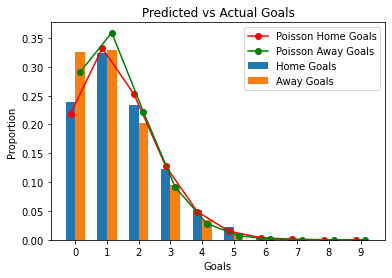

In [6]:
width = 0.3       

plt.bar(goals, HomeGoals , width, label='Home Goals')
plt.bar(goals + width, AwayGoals, width, label='Away Goals')
plt.plot(goals, HomeGoalsPredict, label ='Poisson Home Goals', marker = 'o' , color = 'red')
plt.plot(goals + width, AwayGoalsPredict, label ='Poisson Away Goals', marker = 'o', color = 'green' )

plt.xlabel('Goals')
plt.ylabel('Proportion')
plt.title('Predicted vs Actual Goals')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(goals + width / 2, goals)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

Simple Poisson simply overpredicts the number of higher scoring goal games (i.e. 2, 3 and 4) but underpredicts low scoring and drawing games. I will implement a Dixon Coles model try to more accurately predict

In [7]:
pip install penaltyblog #installing the package used for fitting the Dixon-Coles model

Note: you may need to restart the kernel to use updated packages.


In [8]:
import penaltyblog as pb
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace = True)
data.drop(["index"], axis = 1, inplace = True)

In [9]:
def calculate_mean_rps(dc, df):
    rps = list()
    for idx, row in df.iterrows():
        if row["FTR"] == "H":
            outcome = 0
        elif row["FTR"] == "D":
            outcome = 1
        elif row["FTR"] == "A":
            outcome = 2

        predictions = dc.predict(row["HomeTeam"], row["AwayTeam"]).home_draw_away

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

In [10]:
rps = []
train = data.head(-1*test_size)
test = data.tail(test_size)
for xi in [0, 0.0001, 0.001, 0.0025, 0.01, 0.1]:


    train["weight"] = pb.poisson.dixon_coles_weights(train["Date"], xi)

    dc = pb.poisson.DixonColesGoalModel(
        train["FTHG"],
        train["FTAG"],
        train["HomeTeam"],
        train["AwayTeam"],
        train["weight"])

    dc.fit()
    rps.append(calculate_mean_rps(dc, test))

print(rps) #use xi of 0.0001 as it gives lowest RPS value

<ipython-input-10-342c1048563a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["weight"] = pb.poisson.dixon_coles_weights(train["Date"], xi)
<ipython-input-10-342c1048563a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["weight"] = pb.poisson.dixon_coles_weights(train["Date"], xi)
<ipython-input-10-342c1048563a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

[0.19551511237084818, 0.19543076123015674, 0.19560281594099022, 0.1975319079173741, 0.21540211237661253, 0.26106061003541625]


In [11]:
train = data.head(-1*test_size)
test = data.tail(test_size)

train["weight"] = pb.poisson.dixon_coles_weights(train.Date, 0.0001) 
dc = pb.poisson.DixonColesGoalModel(
    train["FTHG"],
    train["FTAG"],
    train["HomeTeam"],
    train["AwayTeam"],
    train["weight"])

dc.fit()
dc


<ipython-input-11-02a545a8115d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["weight"] = pb.poisson.dixon_coles_weights(train.Date, 0.0001)


Module: Penaltyblog

Model: Dixon and Coles

Number of parameters: 64
Log Likelihood: -3678.507
AIC: 7485.013

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.405                -1.108              
Aston Villa          1.05                 -0.927              
Bournemouth          1.118                -0.767              
Brentford            0.951                -0.917              
Brighton             0.938                -1.007              
Burnley              0.895                -0.964              
Cardiff              0.53                 -0.807              
Chelsea              1.457                -1.258              
Crystal Palace       1.004                -0.85               
Everton              1.14                 -0.976              
Fulham               0.773                -0.801              
Huddersfield         0.48                 -0.753              
Hull     

In [12]:
fixtures_w16 = [    
    ['Brentford', 'Watford'],
    ['Man City', 'Wolves'],
    ['Chelsea', 'Leeds'],
    ['Liverpool', 'Aston Villa'],
    ['Arsenal', 'Southampton'],
    ['Norwich', 'Man United'],
    ['Burnley', 'West Ham'],
    ['Leicester', 'Newcastle'],
    ['Brighton', 'Tottenham'],
    ['Crystal Palace','Everton']] #Inputting the Week 16 Fixtures 

In [13]:
def mse(y_true, y_pred): #function used to calculate Mean Squared Error
    return np.square(np.subtract(y_true,y_pred)).mean() 

In [14]:
def rho_correction(x, y, lambda_x, mu_y, rho): #function to implement the 
                                                #rho-correction proposed in the Dixon Coles Paper
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

In [15]:
def predict(x, y, lambda_x, mu_y, rho):     #prediction function
    rho_tilde = rho_correction(x, y, lambda_x, mu_y, rho)
    probability = rho_tilde * poisson.pmf(x, lambda_x) *  poisson.pmf(y, mu_y)
    return probability 

In [16]:
results = pd.DataFrame({"HomeTeam" : [],   #empty Dataframe to populate
                       "AwayTeam": [],
                       "Predicted_Home_Goals": [],
                        "Predicted_Away_Goals": [],
                       "Probability": [],
                       })

In [17]:
def score_probability(home_team, away_team, model, max_goals):
    param_dict = model.get_params()
    alpha_home = param_dict['attack_' + home_team] 
    alpha_away = param_dict['attack_' + away_team]
    beta_home = param_dict['defence_' + home_team]
    beta_away = param_dict['defence_' + away_team]
    gamma = param_dict['home_advantage']
    rho = param_dict['rho']
    
    lambda_x = -1 * alpha_home * beta_away * gamma
    mu_y = -1 * alpha_away*beta_home
    
    prob_final = 0 #initialising probability, home and away score for the for loop
    x_final = 0
    y_final = 0
    
    for x in range(max_goals+1):
        for y in range(max_goals+1):
        
            prob_temp = predict(x, y, lambda_x, mu_y, rho)

            if prob_temp > prob_final:
                prob_final = prob_temp
                x_final = x
                y_final = y
    r = [fix[0], fix[1], x_final, y_final, prob_final]
    return r

In [18]:
max_goals = 10

for fix in fixtures_w16:
    r = score_probability(fix[0], fix[1], dc, max_goals)
    results = results.append(pd.DataFrame([r], columns=results.columns), ignore_index=True)
    
results['Rank'] = results['Probability'].rank(pct=False, ascending = False)

In [19]:
def mse(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()
    
def model_eval(X, model):
    home_goals_true = X["FTHG"].to_numpy()
    away_goals_true = X["FTAG"].to_numpy()
    home_goals_pred = []
    away_goals_pred = []
    home_teams = X["HomeTeam"].to_numpy()
    away_teams = X["AwayTeam"].to_numpy()
    
    for i in range(len(X)):
        home_team = home_teams[i]
        away_team = away_teams[i]
        
        r = score_probability(home_team, away_team, model, max_goals = 10)
        home_goals_pred.append(r[2])
        away_goals_pred.append(r[3])

    
    home_goals_pred = np.asarray(home_goals_pred)
    away_goals_pred = np.asarray(away_goals_pred)
        
    home_goals_mse = mse(home_goals_true, home_goals_pred)
    away_goals_mse = mse(away_goals_true, away_goals_pred)
    
    return [home_goals_mse, away_goals_mse]

In [20]:
results

,HomeTeam,AwayTeam,Predicted_Home_Goals,Predicted_Away_Goals,Probability,Rank
0,Brentford,Watford,0.0,0.0,0.335879,3.0
1,Man City,Wolves,0.0,1.0,0.203045,10.0
2,Chelsea,Leeds,0.0,1.0,0.242908,9.0
3,Liverpool,Aston Villa,0.0,1.0,0.243077,8.0
4,Arsenal,Southampton,0.0,1.0,0.275600,6.0
5,Norwich,Man United,0.0,0.0,0.374123,1.0
6,Burnley,West Ham,0.0,1.0,0.302721,5.0
7,Leicester,Newcastle,0.0,0.0,0.339667,2.0
8,Brighton,Tottenham,0.0,1.0,0.258691,7.0
9,Crystal Palace,Everton,0.0,0.0,0.312103,4.0


In [21]:
all_mses = model_eval(test, dc)
print(all_mses)

[4.082539682539682, 2.1555555555555554]


In [22]:
#using the expected values as mu and lambda
results_v2 = pd.DataFrame({"HomeTeam" : [],   #empty Dataframe to populate
                       "AwayTeam": [],
                       "Predicted_Home_Goals": [],
                        "Predicted_Away_Goals": [],
                       "Probability": [],
                       })

In [23]:
def score_probability_v2(home_team, away_team, model, max_goals):
    probs = model.predict(home_team, away_team)
    lambda_x = probs.home_goal_expectation 
    mu_y = probs.away_goal_expectation
    rho = dc.get_params()['rho']
    prob_final = 0
    x_final = 0
    y_final = 0
    for x in range(max_goals+1):
        for y in range(max_goals+1):
        
            prob_temp = predict(x, y, lambda_x, mu_y, rho)

            if prob_temp > prob_final:
                prob_final = prob_temp
                x_final = x
                y_final = y
    r = [fix[0], fix[1], x_final, y_final, prob_final]
    return r

max_goals = 10

for fix in fixtures_w16:
    r_v2 = score_probability_v2(fix[0], fix[1], dc, max_goals)
    results_v2 = results_v2.append(pd.DataFrame([r_v2], columns=results_v2.columns), ignore_index=True)
    
results_v2['Rank'] = results_v2['Probability'].rank(pct=False, ascending = False)

In [24]:
results_v2

,HomeTeam,AwayTeam,Predicted_Home_Goals,Predicted_Away_Goals,Probability,Rank
0,Brentford,Watford,1.0,1.0,0.132795,5.0
1,Man City,Wolves,2.0,0.0,0.142480,2.0
2,Chelsea,Leeds,2.0,1.0,0.097382,10.0
3,Liverpool,Aston Villa,2.0,0.0,0.125122,7.0
4,Arsenal,Southampton,2.0,0.0,0.104664,9.0
5,Norwich,Man United,0.0,2.0,0.153982,1.0
6,Burnley,West Ham,1.0,1.0,0.136693,3.0
7,Leicester,Newcastle,1.0,1.0,0.117420,8.0
8,Brighton,Tottenham,1.0,1.0,0.130021,6.0
9,Crystal Palace,Everton,1.0,1.0,0.135599,4.0


In [25]:
def model_eval_v2(X, model):
    home_goals_true = X["FTHG"].to_numpy()
    away_goals_true = X["FTAG"].to_numpy()
    home_goals_pred = []
    away_goals_pred = []
    home_teams = X["HomeTeam"].to_numpy()
    away_teams = X["AwayTeam"].to_numpy()
    
    for i in range(len(X)):
        home_team = home_teams[i]
        away_team = away_teams[i]
        
        r = score_probability_v2(home_team, away_team, model, max_goals = 10)
        home_goals_pred.append(r[2])
        away_goals_pred.append(r[3])

    
    home_goals_pred = np.asarray(home_goals_pred)
    away_goals_pred = np.asarray(away_goals_pred)
        
    home_goals_mse = mse(home_goals_true, home_goals_pred)
    away_goals_mse = mse(away_goals_true, away_goals_pred)
    
    return [home_goals_mse, away_goals_mse]

In [26]:
all_mses_v2 = model_eval_v2(test, dc)
print(all_mses_v2)

[1.7904761904761906, 1.6396825396825396]
